## 분석 배경

관련 뉴스 : https://www.hankyung.com/life/article/2020122267671
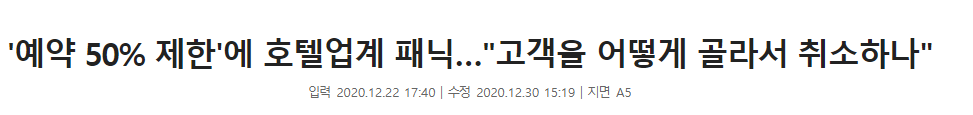


## 호텔 사업 비지니스 문제 및 분석 목표
갑작스런 코로나 집합금지 명령으로 인해 호텔의 수용인원을 제한해야해 전 세계 호텔 업계에 비상이 걸렸다. 

대부분의 숙박업소는 대상 고객을 정하는 기준을 잡기도 모호해 고객의 자발적인 취소를 기대해야 하는 상황이다.

호텔 예약 수요 데이터로 잠재적 취소 고객을 예측하는 모델을 만들어 호텔의 수용인원을 조절하는 것을 목표로 한다.

또한 전 세계 호텔 데이터 분석을 하고 고객 관리에 대한 인사이트를 얻는다.



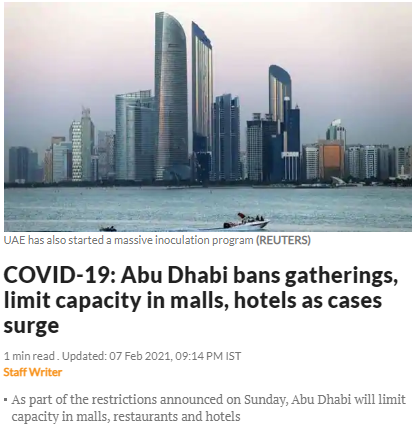

### **데이터 불러오기**

In [ ]:
import pandas as pd
from google.colab import files
files.upload()

In [ ]:
!pip install --upgrade category_encoders

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 데이터 불러오기
df = pd.read_csv('hotel_bookings.csv')

In [5]:
# target2
df_no_show=df['reservation_status']

### **Target data 확인**

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64


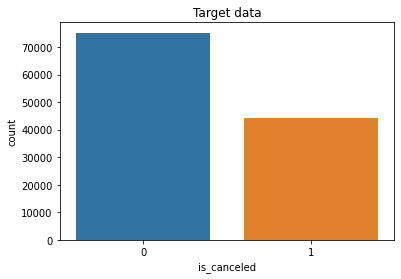

In [6]:
## 결측치정리 필요 # arrival features 정리 필요
# df.info()

##Target 분포  
# df['is_canceled'].unique()
print(df['is_canceled'].value_counts(normalize=True))
sns.countplot(x='is_canceled',data=df);
plt.title("Target data");

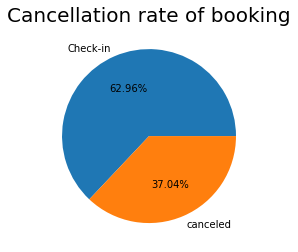

In [7]:
group_names = ['Check-in','canceled']
group_sizes = [0.629584, 0.370416]

group_colors = ['#28527a', 'orange']

plt.pie(group_sizes, 
        labels=group_names, 
        autopct='%1.2f%%')

plt.title('Cancellation rate of booking', fontsize=20)

plt.show()


사용할 평가지표와 기준 모델을 정하기 위해서 위와 같이 타겟의 분포를 시각화하였다. 그림을 통해 알 수 있듯이, 0과 1이 약 6:4로 꽤 고르게 분포되어 있다. 따라서 모델의 성능을 평가할 대표 지표로 정확도(Accuracy)를 사용하기로 했습니다. 그리고 기준 모델은 데이터를 모두 최빈 클래스인 0, 즉 모든 예약이 취소되지 않을 것이라고 예측하는 것으로, 정확도는 약 63%이다. 따라서 앞으로 우리가 만들 모델은 정확도가 약 0.63보다 높아야 학습이 잘 된 모델이라고 말할 수 있다.

### **이상치 & 결측치 & Data Leakage 확인**

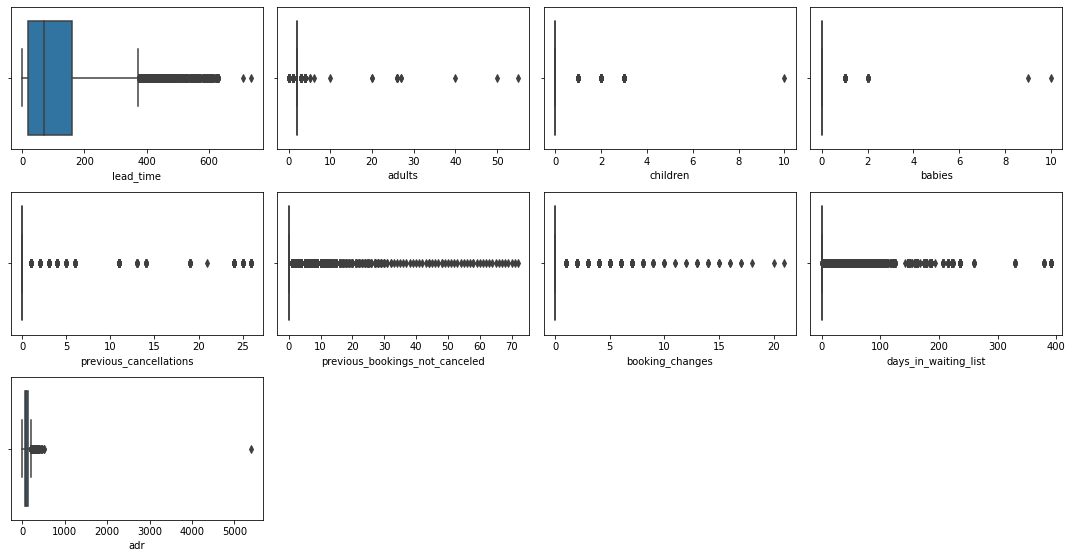

In [8]:
#이상치 확인
df.describe()
#boxplot으로 이상치 확인
features = ['lead_time', 'adults','children',	'babies',	'previous_cancellations',	'previous_bookings_not_canceled'	,'booking_changes','days_in_waiting_list','adr']
n = 1
plt.figure(figsize=(15,10))
for feature in features:
    plt.subplot(4,4,n)
    sns.boxplot(df[feature]);
    n+=1
    plt.tight_layout();

In [9]:
df.describe(exclude=np.number)

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461


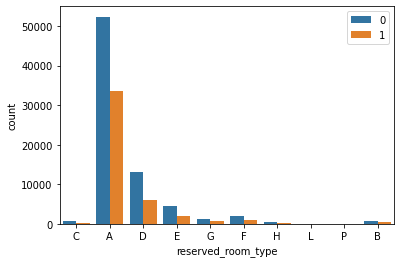

In [10]:
#실제로 예약한 방
sns.countplot(x='reserved_room_type',hue='is_canceled' ,data=df)
plt.legend(loc='upper right')

- room A 의 예약률과 취소율이 제일 높다.
- room L,P 제거하기

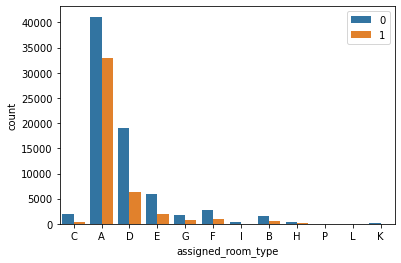

In [11]:
#당일에 할당된 방
sns.countplot(x='assigned_room_type',hue='is_canceled' ,data=df)
plt.legend(loc='upper right')
plt.set_ylim=(0,50000)

In [12]:
#이상치 변환 및 제거

chi10=df[df['children'] >= 9].index
df.drop(chi10,inplace=True)

df['babies'].value_counts()
bab=df[df['babies'] >= 8].index
df.drop(bab, inplace=True)

df['adults'].value_counts()
adu=df[df['adults'] >= 9].index
df.drop(adu, inplace=True)

#wating=df[df['days_in_waiting_list'] > 300].index / 나중에 파라미터 조정
#df.drop(wating,inplace=True)

#이전 취소전적 / 새로운 특성 만들기 위해 이상치나중에 제거
#pbnc=df[df['previous_bookings_not_canceled']>40].index
#df.drop(pbnc, inplace=True)

# Reserved_room_type 호텔 방 이상치 P,L 삭제
type_p=df[df['reserved_room_type'] == "P"].index
df.drop(type_p,inplace=True)
type_l=df[df['reserved_room_type'] == "L"].index
df.drop(type_l, inplace=True)

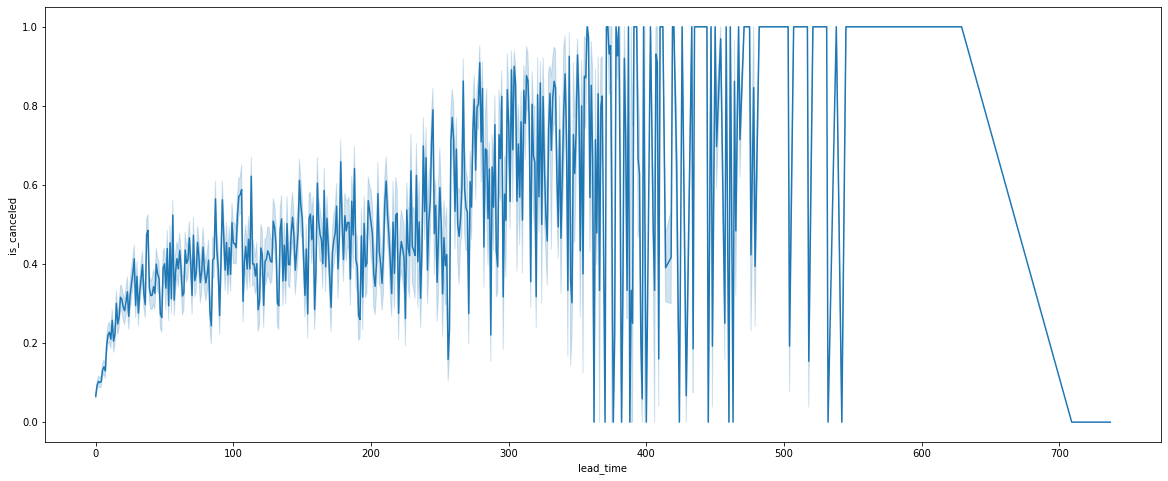

In [13]:
plt.figure(figsize=(20,8))
sns.lineplot(x='lead_time',y='is_canceled',data=df)

In [14]:
# lead time 이상치 365으로 맞추기
df.loc[df.lead_time > 365,'lead_time']=365

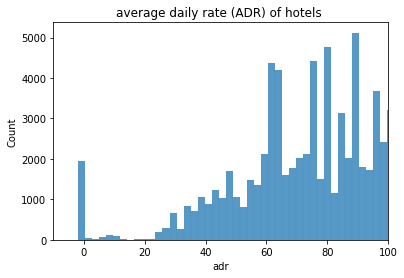

In [15]:
# 하루평균요금의 이상치 0원 혹은 마이너스인경우.
df['adr'].describe()
sns.histplot(x='adr', data=df)
plt.xlim(-10,100);
plt.title('average daily rate (ADR) of hotels ');

- 숙박 비용이 마이너스 이거나 0원인 경우는 이벤트 등으로 인해 무료로 이용한 경우일 수도 있고, 입력 오류 일 수도 있다.  - 평균요금으로 전환


In [16]:
#하루평균요금 이상치 제거
adr_out=df[df['adr'] > 5000].index
df.drop(adr_out,inplace=True)
# 0과 마이너스 값 평균으로 대체
mean = df['adr'].mean()
df['adr']=df['adr'].apply(lambda x : mean if x <= 0 else x)

In [17]:
# 결측치 
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              478
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16314
company         

In [18]:
#사용하지 않을 특성 제거
#reservation_status & date 는 미래 상황이므로 제거
df=df.drop(['arrival_date_week_number','company','reservation_status','reservation_status_date'],axis=1)

# country 결측치 => others
df['country'].value_counts()
df['country'].unique()
df['country'].fillna('Others',inplace=True)

# children 결측치 0으로 바꾸고 int로 타입변환
df['children'].fillna(0, inplace=True)
df['children'].astype(int).value_counts()

#agent 결측치 개수가 애매함
#df['agent'].value_counts().head(10)
#agent 결측치 n으로 통일
df['agent'].value_counts()
df['agent']=df['agent'].astype(str).apply(lambda x: 'No.' + x[0:-2] if x != np.nan else 0)

- reservation_status (예약현황)과 reservation_status_date(예약현황일) 두 특성은 예약일 당일에만 알 수 있는 데이터(미래데이터)이기도 하며 특히 예약현황은 Target Data와 같기 때문에 Data Leakage가 일어날 수 있기에 제거해야한다.
- 특성 assigned_room_type도 당일에 알 수 있는 데이터이기 때문에 나중에 제거하도록 한다.

### **feature wrangling**

In [19]:
# arrival_date_month 문자에서 숫자로 변환
df['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

# 호텔 숙박 총 일수 생성 , 기존 열 제거
df['stays_nights']=df['stays_in_weekend_nights']+df['stays_in_week_nights']

#df.drop(['stays_in_week_nights','stays_in_weekend_nights'],axis=1,inplace=True)

#호텔 게스트 수, 아이 수 => 새로운 열 추가 , 오리지널 데이터 삭제
df['total_guest']=df['adults']+df['children']+df['babies']
df['children']=df['children']+df['babies']
df.drop(['adults','babies'],axis=1,inplace=True)
#게스트 수 0명 -> 평균
#df['guest'].value_counts()
df['total_guest'].replace(0.0,df['total_guest'].mode()[0],inplace=True)
df['total_guest'].astype(int).value_counts()

2    82214
1    22580
3    10495
4     3928
5      137
6        1
Name: total_guest, dtype: int64

### **Creat New feature**

호텔 이용객들의 과거 취소 전적 데이터로 취소율 계산하고 취소할 확률이 낮은 사람부터 등급 매기기.

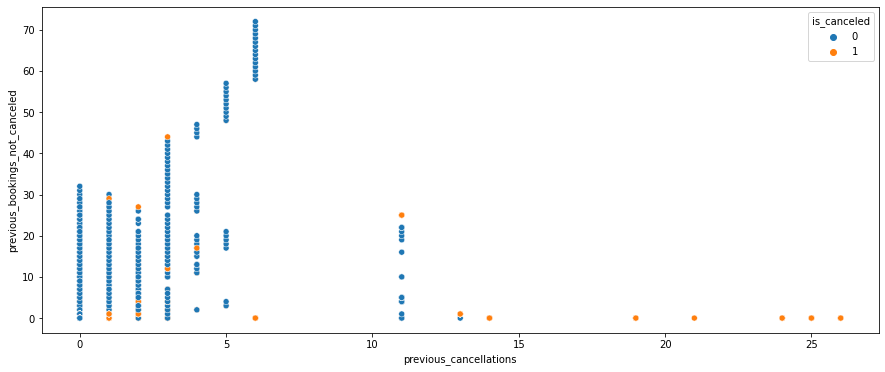

In [20]:
# 과거 예약 취소/미취소한 전적의 데이터로 취소 비율 살펴보기
plt.figure(figsize=(15,6))
sns.scatterplot(x='previous_cancellations', y='previous_bookings_not_canceled',hue='is_canceled' ,data=df);

위 그래프로 이전에 호텔을 이용한 전적보다 취소한 전적이 더 많은 사람이 취소할 경우가 많고, 호텔을 이용한 횟수가 높으면 취소를 안 할 가능성이 높음을 알 수 있다.

In [21]:
# 호텔 이용객 취소율로 신용등급 지정하기 (vip data 따로 추출)
vip=df[['previous_cancellations','previous_bookings_not_canceled']]
#vip.info()
# 호텔 이용객 취소율 낮은 순 부터 신용 등급매기기 # 취소 안 할 확률 / (취소 할 확률 + 취소 안 할 확률)
vip=vip.astype(float)
vip['cancellation_rate']=vip['previous_bookings_not_canceled']+vip['previous_cancellations']
vip['cancellation_rate']=vip['previous_bookings_not_canceled']/vip['cancellation_rate']

# 순위 A~F (N열외)
def rate(value) :
  y = value*100
  cat = ''       
  if y == 100 :
     cat = 'S'    # 미취소율 100% : S등급
  elif y > 66 : 
    cat = 'A'     # 66% < x < 100% : A등급
  elif y >= 50 : 
    cat = 'B'     # 50% <= x < 66% : B등급
  elif y >=25 : 
    cat ='C'      # 25% <= x < 50% : C등급
  elif y >=10 : 
    cat ='D'      # 10% <= x < 25% : D등급
  elif y > 0: 
    cat='E'       # 0% < x < 1% : E등급
  elif y == 0 : 
    cat='F'       # 미취소율 0% : F등급
  else : 
    cat='N'       # 호텔 처음 이용 (or 기록x ) : N
  return cat
  
vip['cancellation_rating']= vip['cancellation_rate'].apply(lambda y : rate(y))
vip=vip['cancellation_rating']


고객 별 취소율 등급을 지정해 등급이 낮은 고객 순으로 취소 메일을 보낼 수 있다. 또 취소등급이 높은 고객에게 알맞은 혜택과 이벤트 등을 제공함으로써 단골유치와 무분별한 예약 취소를 방지에 도움이 될 것으로 생각한다.

In [22]:
# 예약한 방과 할당된 방이 서로 다를 때 : 1 ,같을 때 0 (나중에 assigned_room_type 제거하기(미래데이터))
df['room_changed']=df.apply(lambda x : 1 if x['reserved_room_type'] != x['assigned_room_type'] else 0,axis=1)

In [23]:
# 호텔 총 이용금액 특성 추가하기
df['total_bill']=df['adr']*df['stays_nights']

In [24]:
# stays in week/weekend가 모두 0인 행 = 호텔요금(adr)이 0 임을 확인
condition1=((df['stays_in_weekend_nights']==0) & (df['stays_in_week_nights']==0))
data=df[condition1]
condition2 = df['adr']==0
data1=df[condition1 &condition2]

In [25]:
## 새로운 피처 만들기 : `Weekday vs Weekend`

def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            df['weekend_or_weekday'].iloc[i] = 'weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'weekday&weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
           df['weekend_or_weekday'].iloc[i] = 'undefined_data'

week_function(df['stays_in_weekend_nights'],df['stays_in_week_nights'], df)
#'stays_in_weekend_nights','stays_in_week_nights'삭제
df.drop(['stays_in_weekend_nights','stays_in_week_nights'],axis=1,inplace=True)

In [26]:
df['weekend_or_weekday'].value_counts()

weekday&weekend    60447
weekday            51275
weekend             6929
undefined_data       704
Name: weekend_or_weekday, dtype: int64

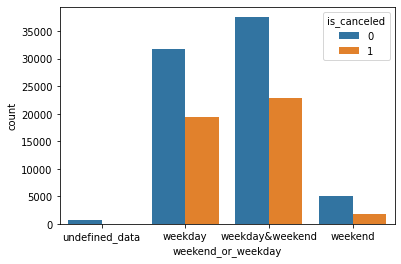

In [27]:
sns.countplot(x='weekend_or_weekday',hue='is_canceled', data=df);

주중&주말 이 호텔 이용객 수가 많고 그 다음 주말이 많을 것으로 예상했지만, 의외로 주중이 많음.
주중&주말이 예약률이 가장 많으며 취소율도 가장 많다. 그 다음 순으로 주중의 예약이 많고 취소율도 그 두번째로 많다. 주말은 예상 외로 예약 수가 적다.

### **데이터 정리하기**


In [28]:
# 기본데이터 df와 손님등급 특성 새로만든 vip 데이터 합치기 
whole=pd.concat([df,vip], axis=1).rename(columns={0 : 'cancellation rating'})
whole.reset_index(drop='index',inplace=True)
whole.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stays_nights,total_guest,room_changed,total_bill,weekend_or_weekday,cancellation_rating
0,Resort Hotel,0,342,2015,7,1,0.0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,No.n,0,Transient,101.806853,0,0,0,2.0,0,0.0,undefined_data,N
1,Resort Hotel,0,365,2015,7,1,0.0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,No.n,0,Transient,101.806853,0,0,0,2.0,0,0.0,undefined_data,N
2,Resort Hotel,0,7,2015,7,1,0.0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No.n,0,Transient,75.000000,0,0,1,1.0,1,75.0,weekday,N


In [29]:
df_no_show

0         Check-Out
1         Check-Out
2         Check-Out
3         Check-Out
4         Check-Out
            ...    
119385    Check-Out
119386    Check-Out
119387    Check-Out
119388    Check-Out
119389    Check-Out
Name: reservation_status, Length: 119390, dtype: object

In [30]:
# tran/val/test 데이터 분할하기
from sklearn.model_selection import train_test_split
train, test = train_test_split(whole, test_size=0.20, 
                              random_state=10)
train, val = train_test_split(train, test_size=0.30, 
                              random_state=10)
train.shape, val.shape, test.shape

((66838, 30), (28646, 30), (23871, 30))



---


### **데이터 컬럼 분할해서 분석하기**
데이터 컬럼이 너무 많은 관계로 데이터를 컬럼을 나눠서 분석하겠습니다.



In [31]:
# train 데이터 컬럼 분할하기(중복있음)
hotel = train[['hotel','country','market_segment','distribution_channel','agent','adr','stays_nights','total_bill','reserved_room_type','assigned_room_type','room_changed','deposit_type','is_canceled']]
guest = train[['total_guest','children','customer_type','is_repeated_guest','previous_cancellations','previous_bookings_not_canceled','cancellation_rating','is_canceled']]
date = train[['arrival_date_year','arrival_date_month','arrival_date_day_of_month','weekend_or_weekday','stays_nights','lead_time','days_in_waiting_list','is_canceled','cancellation_rating']]
service = train[['meal','booking_changes','deposit_type','required_car_parking_spaces','total_of_special_requests','is_canceled']]

#### **1. [ hotel data ]**
- Hotel : (H1 = Resort Hotel or H2 = City Hotel)
- country : 고객의 국적 (범주는 ISO 3155-3 : 2013 형식으로 표현됩니다.)
- market_segment : 시장세분화 지정. (TA :Travel Agents/ TO: Tour Operators)
- distribution_channel : 예약 유통 채널  (TA :Travel Agents/ TO: Tour Operators)
- agent :예약한 travel agency의 ID
- adr : Average Daily Rate 하루 평균 요금 (총 숙박요금 / 총 숙박일)
- stay_nights : 호텔에 머무른 총 날짜 수   **(new feature)**
- total_bill : 호텔 총 이용요금 (adr * stay_nights)  **(new feature)**
- reserved_room_type : 고객이 예약했던 룸
- assigned_room_type : 예약에 지정된 룸 유형에 대한 코드. (때때로 지정된 룸 유형은 예약된 룸 유형과 다름.) 
- room_chaned : 예약한 방과 할당된 방이 다를 때 1, 같을 때 0 **(new feature)**
- is_canceled : 예약 취소 (1) 취소안함 (0) **(Target data)**

In [32]:
hotel.head(3)

,hotel,country,market_segment,distribution_channel,agent,adr,stays_nights,total_bill,reserved_room_type,assigned_room_type,room_changed,deposit_type,is_canceled
50149,City Hotel,FRA,Online TA,TA/TO,No.9,134.98,5,674.9,D,D,0,No Deposit,1
18246,Resort Hotel,PRT,Corporate,Corporate,No.185,37.60,10,376.0,A,F,1,No Deposit,0
22597,Resort Hotel,PRT,Direct,Direct,No.n,43.00,1,43.0,A,A,0,No Deposit,0


가설
1. Resort hotel 보다 City 쪽의 호텔의 취소율이 높을 것이다. (Resort는 휴식을 취하러 가는 목적이 많은 것에 반면, City hoel은 여행, 비지니스, 파티 등의 다양한 방문 목적이 있고, 다양하고 많은 사람들이 이용하기 때문에 그에 따른 변수도 많아 취소율이 더 높을 것으로 생각된다.)
2. 평소 호텔 예약 시 호텔에 직접 예약하거나 여행사를 가기보다는 주로 온라인을 이용하는 경우가 많을 것이다. 취소율 비율 또한 온라인이 높을 것 같다.
3. 예약한 방과 할당된 방이 다를 경우 더 좋은 방에 지정될 것일까? 만약 좋은 방에 지정된다면 취소율이 낮을까?
4. 호텔 요금이 비쌀수록 보증금이 있을 것이다. 보증금이 있으면 취소율이 적을 것이다.

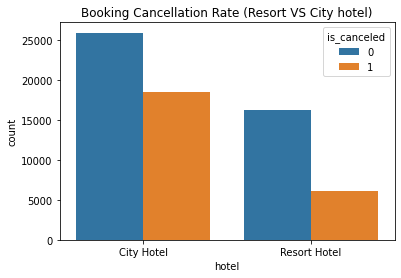

In [33]:
#가설1 : Resort hotel 보다 City hotel의 취소율이 더 높을 것이다.
sns.countplot(x='hotel',hue='is_canceled',data=hotel);
plt.title('Booking Cancellation Rate (Resort VS City hotel)');

가설1 에 대한 분석 결론
- 외곽의 리조트 호텔보다 도시 호텔의 이용률(데이터)이 훨씬 많음.
- 도시에 있는 호텔일수록 예약 취소율이 높음. 리조트호텔 예약 취소율의 약 3배이다.

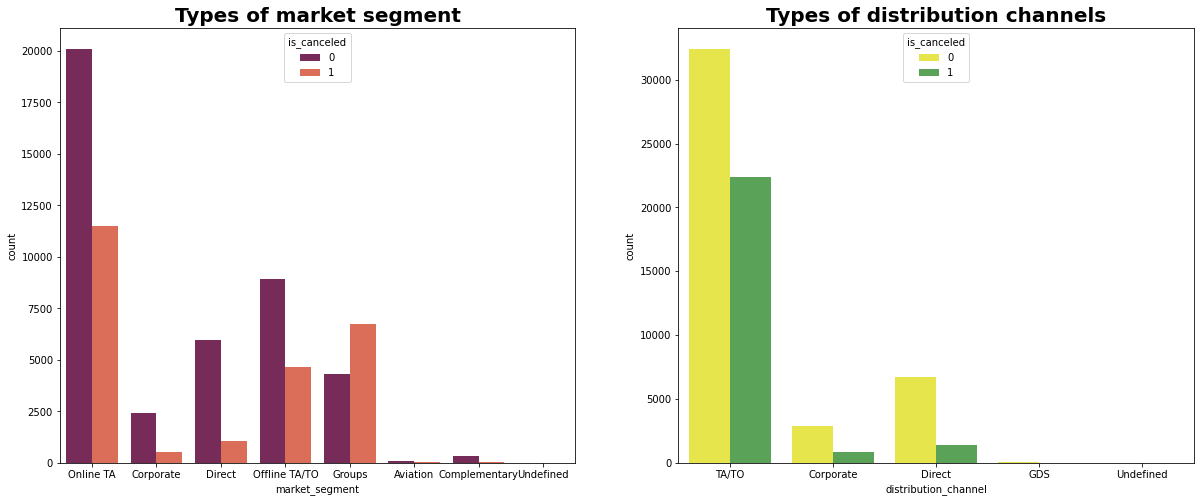

In [34]:
## 가설2. 온라인으로 호텔을 예약하는 경우가 많을 것이다. 취소율 또한 많을 것이다. 
#나중에 파이차트로 바꾸기
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
sns.countplot(x='market_segment', data=hotel, hue='is_canceled' ,palette='rocket')
plt.title('Types of market segment',fontweight="bold", size=20)

plt.subplot(1, 2, 2)
sns.countplot(data = hotel, x = 'distribution_channel', hue='is_canceled',  palette='Set1_r')
plt.title('Types of distribution channels',fontweight="bold", size=20)
plt.subplots_adjust(right=1.7)



plt.show()

가설 2에 대한 분석 결론

** GDS(Global Distribution System)는 여행사에서 예약 및 판매와 렌터카, 호텔 예약 등을 보다 용이하게 할 목적으로 개발된 컴퓨터 시스템
** TA : Travel Agents
** TO : Travel Operators

- 온라인 예약 사이트에서 예약이 가장 많이 이뤄지며 그 다음은 오프라인,그룹, 호텔 직접 예약 순이다. 취소 비율은 Groups가 가장 많음. (패키지 여행사로 생각됨)

In [35]:
import plotly 
import plotly.express as px
import plotly.graph_objs as go

temp = hotel['country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})
guest_map = px.choropleth(temp,
                          locations=temp['country'],
                          color=np.log(temp['count']), 
                          hover_name=temp['country'], 
                          color_continuous_scale=px.colors.sequential.Plasma,
                          title="Home country of guests")
guest_map.show()

In [36]:
# 나라 별 호텔 이용객 수 TOP10
count=hotel.country.value_counts().head(10)
count

PRT    27230
GBR     6799
FRA     5886
ESP     4800
DEU     4036
ITA     2121
IRL     1917
BEL     1320
BRA     1232
USA     1186
Name: country, dtype: int64

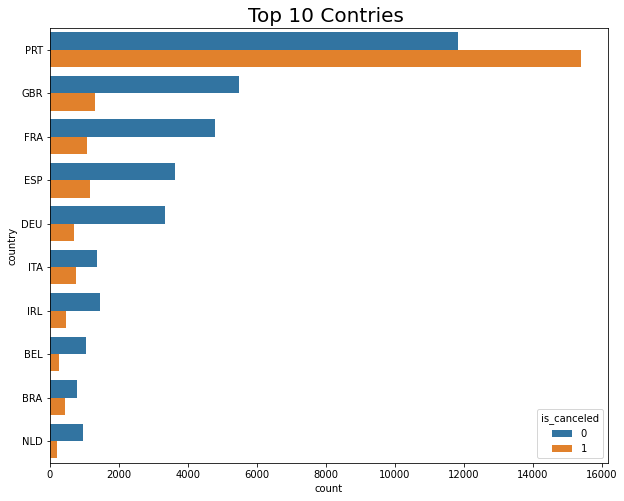

In [37]:
plt.figure(figsize=(10,8))
a=["PRT","GBR","FRA","ESP","DEU","ITA","IRL","BEL","BRA","NLD"]
sns.countplot(y='country', hue='is_canceled',data=hotel, order=a)
plt.title('Top 10 Contries ', fontsize=20);

- PRT : 포르투갈
- GBR : 영국
- FRA : 프랑스
- ESP : 스페인
- DEU : 독일
- ITA : 이탈리아
- IRL : 아일랜드
- BEL : 벨기에
- BRA : 브라질
- NLD : 네덜란드

포르투갈인의 데이터가 가장 많으며 취소율이 가장 높다. 호텔 이용 고객의 국적이 모델에 영향을 많이 줄 것이다.

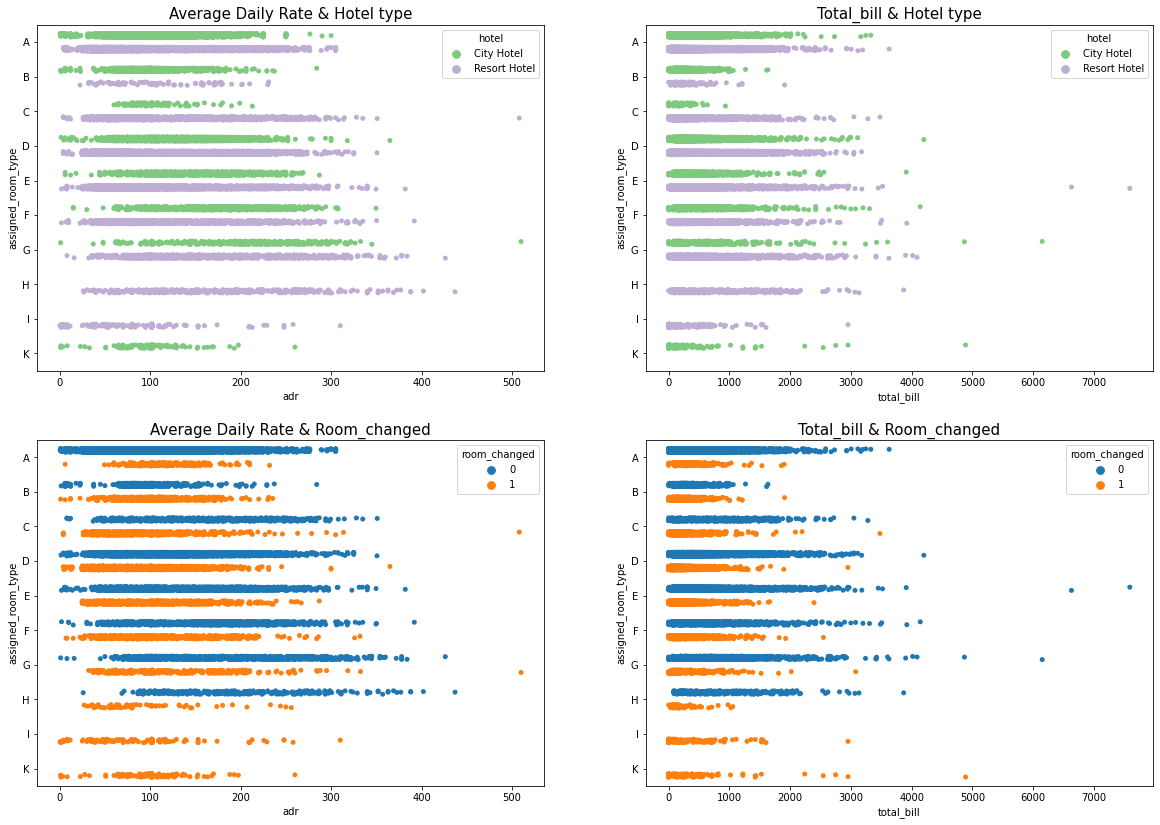

In [38]:
# 가설3 : 예약한 방과 할당된 방이 다를 경우 더 좋은 방으로 지정될 것이다. 그리고 취소율이 낮을 것이다.
plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
b=['A','B','C','D','E','F','G','H','I','K']
sns.stripplot(x="adr", y="assigned_room_type",hue='hotel',data=hotel, jitter=True, dodge=True, palette='Accent',order=b)
plt.title('Average Daily Rate & Hotel type', fontsize=15)
plt.subplot(2,2,2)
sns.stripplot(x="total_bill", y="assigned_room_type",hue='hotel', data=hotel, jitter=True,dodge=True,palette='Accent',order=b)
plt.title('Total_bill & Hotel type', fontsize=15)
plt.subplot(2,2,3)
sns.stripplot(x="adr", y="assigned_room_type",hue='room_changed', data=hotel, jitter=True, dodge=True,order=b)
plt.title('Average Daily Rate & Room_changed', fontsize=15)
plt.subplot(2,2,4)
sns.stripplot(x="total_bill", y="assigned_room_type",hue='room_changed', data=hotel, jitter=True, dodge=True,order=b)
plt.title('Total_bill & Room_changed', fontsize=15)
plt.show()

- 먼저 첫번째 줄 그래프들을 보면 room H와 I는 리조트에만 있는 방으로 보이며, room K는 시티호텔에만 있는 방으로 알 수 있다.
- 두번째 줄 그래프들에서 room H와 room I의 차이점을 보면, room H는 손님들이 예약할 수 있 방이지만, room I는 예약할 때는 존재하지 않는 방으로 스페셜한 방으로 보인다. 또한 adr에서 room H 는 직접 예약할 때의 방보다 방이 변경될 때 하루평균요금이 더 저렴한 것을 보아, 예약한 방에 문제가 생겨 방이 H로 변경될 때는 저렴한 가격으로 이용하는 특혜가 있다.
- 시티호텔의 room K는 손님이 직접 예약할 수 없는 방으로, 원래 예약한 방에 문제가 있어 방이 K로 변경 될 때는 저렴한 가격으로 이용가능 하다.
- 두번째 줄 그래프를 보면 손님이 예약한 방(0)보다 할당된 방(1)의 total_bill이 상대적으로 적은 것을 보아 대체적으로 방이 저렴하며 머무르는 시간이 짧은 것을 알 수 있다.

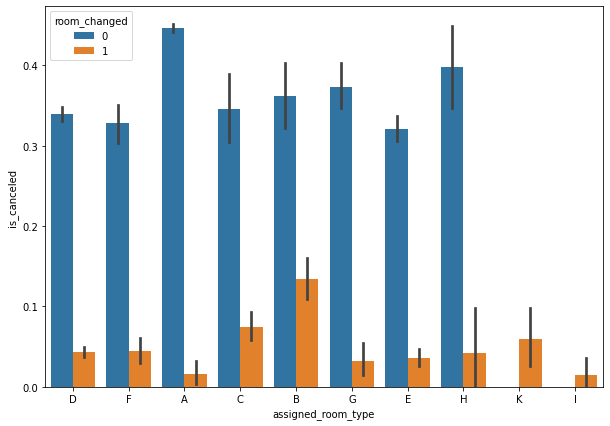

In [39]:
plt.figure(figsize=(10,7))
sns.barplot(x='assigned_room_type',y='is_canceled',hue='room_changed', data=hotel)

가설 3에 대한 분석 결론

- 예약할 때와 다르게 방이 배정되는 경우 취소율이 적음을 알 수 있다.
- 대체적으로 방이 변경될 때 좀 더 저렴한 가격으로 이용할 수 있는 특혜가 있으며 그로인해 취소율이 낮다. (방이 좋은 것은 알 수 없지만, K는 리조트에만 존재하고 H와 I는 시티호텔에만 존재하는 Extra 방이다. 
- overbooking 되거나 손님의 특별한 요구가 있을 경우 사용되는 방으로 예상해본다.
- assigned_room_type 피처는 예약 당일에 알 수 있는 데이터이기 때문에 예측 데이터 특성을 알맞지 않다고 생각해 삭제함.

In [40]:
whole.drop('assigned_room_type',axis=1,inplace=True)

In [41]:
hotel['deposit_type'].value_counts()

No Deposit    58565
Non Refund     8187
Refundable       86
Name: deposit_type, dtype: int64

(0.0, 100.0)

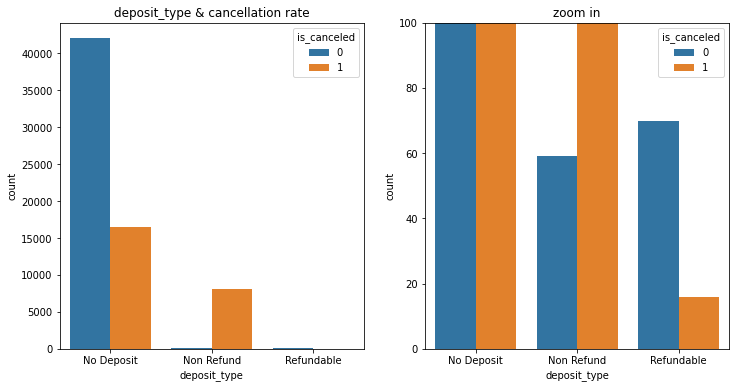

In [42]:
# 가설4. 호텔 요금이 비쌀수록 보증금이 있을 것이다. 보증금이 있으면 취소율이 적을 것이다.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(x='deposit_type',hue='is_canceled',data=hotel)
plt.title('deposit_type & cancellation rate')
plt.subplot(1,2,2)
sns.countplot(x='deposit_type',hue='is_canceled',data=hotel)
plt.title('zoom in')
plt.ylim(0,100)

- No deposit : 보증금 없음
- Non refundable deposit : 보증금 환불불가
- Refundable : 보증금 환불가능

- 대부분 호텔예약시 보증금이 없으며, 취소율이 가장 높다.
- 보증금이 Non Refund 일 경우 취소비율이 낮을 줄 알았는데 의외로 예약율보다 훨씬 높았다.

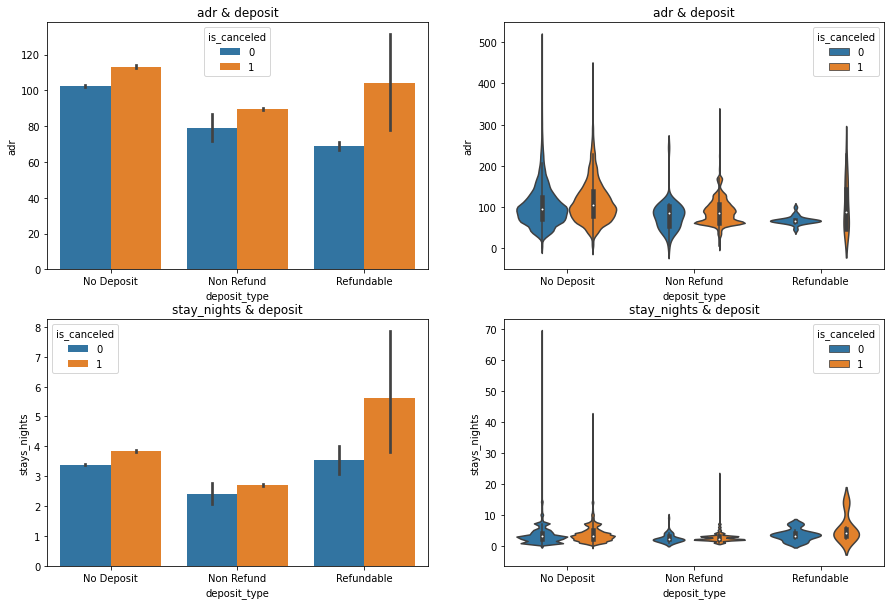

In [43]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(x='deposit_type',y='adr',hue='is_canceled',data=hotel);
plt.title('adr & deposit');
plt.subplot(2,2,2)
sns.violinplot(x='deposit_type',y='adr',hue='is_canceled',data=hotel);
plt.title('adr & deposit');
plt.subplot(2,2,3)
sns.barplot(x='deposit_type',y='stays_nights',hue='is_canceled',data=hotel);
plt.title('stay_nights & deposit');
plt.subplot(2,2,4)
sns.violinplot(x='deposit_type',y='stays_nights',hue='is_canceled',data=hotel);
plt.title('stay_nights & deposit');

가설4에 대한 분석 결론

- 가설과 다르게 비싼방이거나 장기간 체류일 경우에는 Deposit이 없다.
- 전체적으로 No deposit의 비율이 높아 취소율도 제일 높지만, Non refundable인 경우 취소비율이 체크인 비율보다 훨씬 높았다.
- 평균으로 봤을 때 취소한 방의 가격이 높고 장기체류인 것들이 많다.

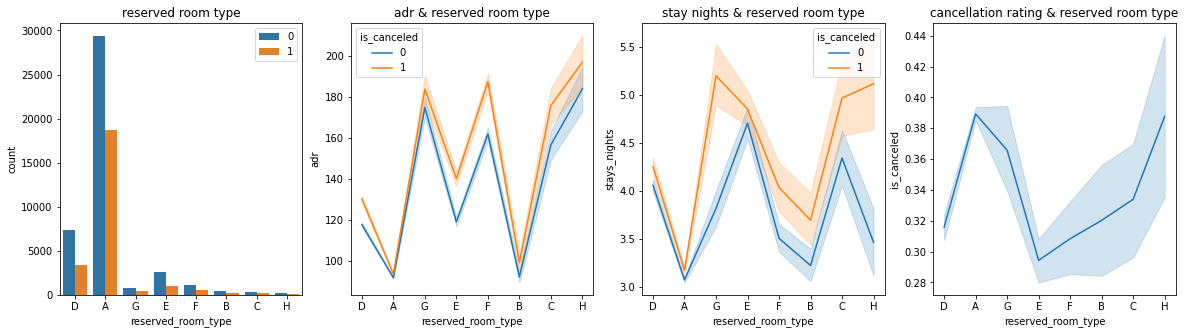

In [44]:
# 예약한 방
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.countplot(x='reserved_room_type',hue='is_canceled' ,data=hotel)
plt.legend(loc='upper right')
plt.title('reserved room type');
plt.subplot(1,4,2)
sns.lineplot(x='reserved_room_type',y='adr',hue='is_canceled',data=hotel);
plt.title('adr & reserved room type');
plt.subplot(1,4,3)
sns.lineplot(x='reserved_room_type',y='stays_nights',hue='is_canceled',data=hotel);
plt.title('stay nights & reserved room type');
plt.subplot(1,4,4)
sns.lineplot(x='reserved_room_type',y='is_canceled',data=hotel);
plt.title('cancellation rating & reserved room type');

- A방은 저렴하고 머무르는 기간도 짧으며 다른 방에 비해 예약율이 높고 취소율도 높다.
- E 방은 중간 가격에 평균적으로 예약기간이 4.5일 이상이며 취소율이 가장 낮은 방이다.

#### **2. [ guest data ]**
- total_guest : 호텔 이용 총 고객 수(어른+아이+아기) **(new feature)**
- children : 아이 동반 수 (아이+아기) **(changed feature)**
- customer_type : 예약 유형, 4 가지 
- is_repeated_guest : 재방문 고객 (1) or not (0)
- previous_cancellations : 고객이 과거에 취소한 예약 개수
- previous_bookings_not_canceled : 고객이 과거에 취소하지 않은 예약 개수
- cancellation_rating : 고객 별 취소등급(S~F등급:취소률이 낮은 순, N: 과거 취소내역 정보가 없는 고객) **(new feature)**
- is_canceled : 예약 취소 (1) 취소안함 (0) **(Target data)**

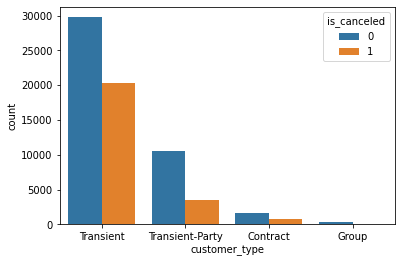

In [45]:
sns.countplot(x='customer_type',hue='is_canceled', data=guest)

- Transient : 단기로 머무는 일반 여행객
- Transient-Party : 일행이 있는 일반 여행객들
- Contract : 비지니스 예약 손님
- Group : 그룹

예약 1건의 일반 여행객의 손님 타입이 주를 이루고 있음. 취소율 또한 가장 높음

#### **3. [ date data ]**
- arrival_date_year : 호텔 도착일의 년도
- arrival_date_month : 호텔 도착일의 월
- arrival_date_day_of_month : 호텔 도착일
- weekend_or_weekday : 주중예약인지 주말예약인지 (weekday / weekend / weekday & weekend / undefined_data) **(new feature)**
- stays_nights : 호텔에 머무른 총 날짜 수   **(new feature)**
- lead_time : PMS(Project Management System)에 예약한 날짜와 도착 날짜 사이에 경과한 일 수
- days_in_waiting_list : 고객이 예약을 확정하기 전까지의 예약 대기 상태 일수
- is_canceled : 예약 취소 (1) 취소안함 (0) **(Target data)**

In [46]:
date.head(3)

,arrival_date_year,arrival_date_month,arrival_date_day_of_month,weekend_or_weekday,stays_nights,lead_time,days_in_waiting_list,is_canceled,cancellation_rating
50149,2016,4,24,weekday&weekend,5,42,0,1,N
18246,2015,11,5,weekday&weekend,10,34,0,0,N
22597,2016,3,30,weekday,1,0,0,0,N


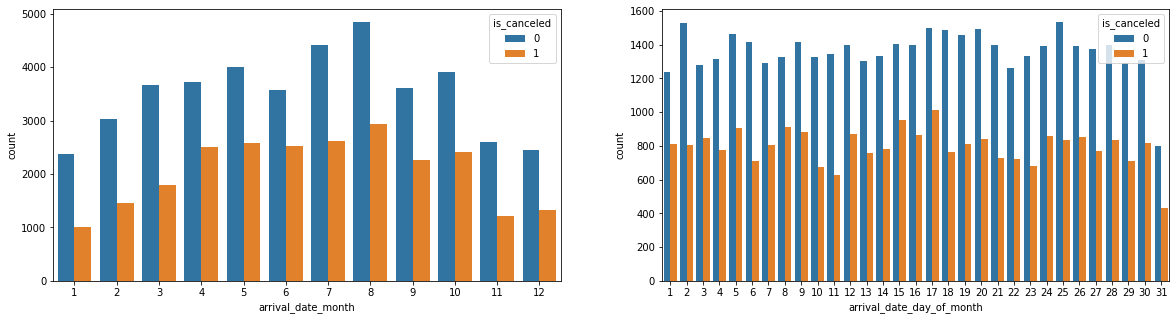

In [47]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
# set categorical order
train['arrival_date_month'] = pd.Categorical(train['arrival_date_month'],
                                   categories=['1','2','3','4','5','6','7','8','9','10','11','12'],
                                   ordered=True)
sns.countplot(x='arrival_date_month',hue='is_canceled',data=train)
plt.subplot(1,2,2)
sns.countplot(x='arrival_date_day_of_month', hue='is_canceled',data=train)

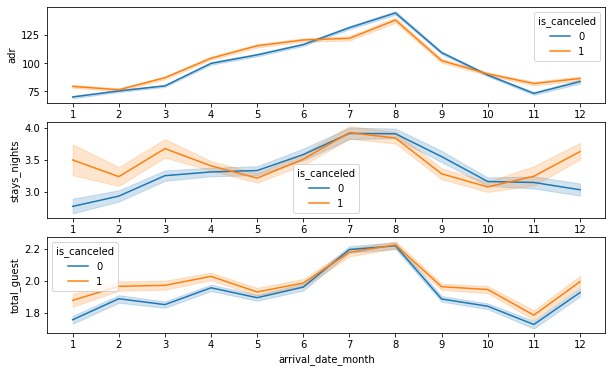

In [48]:
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
sns.lineplot(x='arrival_date_month', y='adr', hue='is_canceled' ,data=train)
plt.subplot(3,1,2)
sns.lineplot(x='arrival_date_month', y='stays_nights', hue='is_canceled' ,data=train)
plt.subplot(3,1,3)
sns.lineplot(x='arrival_date_month', y='total_guest', hue='is_canceled' ,data=train)

- 7~ 8월 성수기에 호텔 예약률이 높고, 11월~1월 비성수기에 예약률이 낮다.
- 31일에 예약률이 가장 낮다.
- 12월~3월에 취소된 예약들은 평균 예약날짜가 긴 편이다.

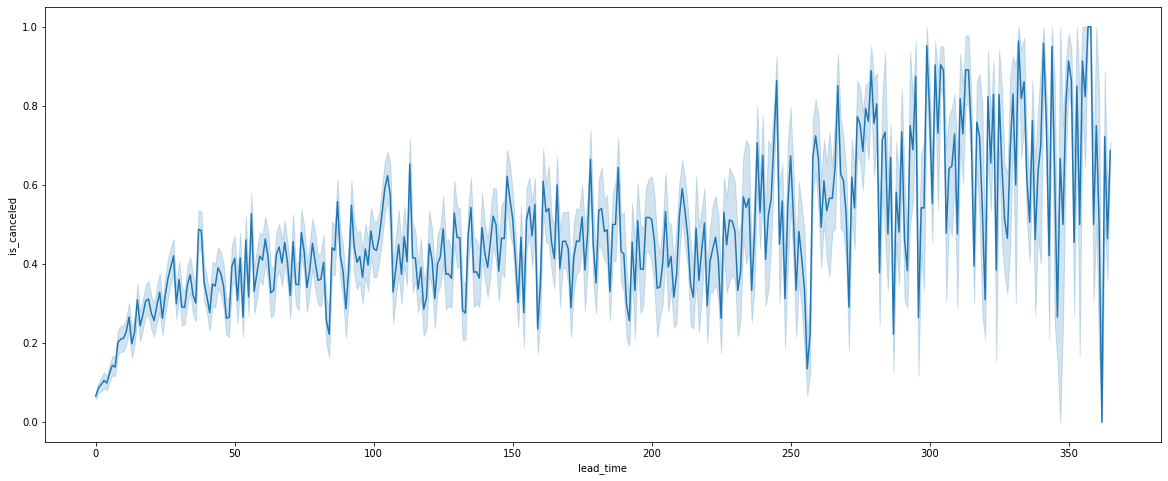

In [49]:
plt.figure(figsize=(20,8))
sns.lineplot(x='lead_time',y='is_canceled',data=date)

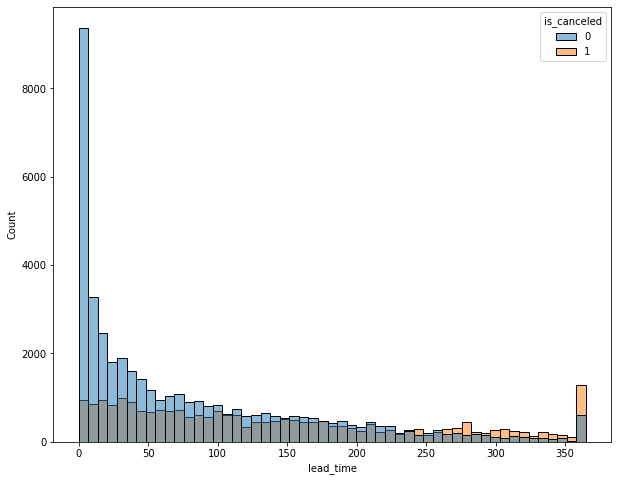

In [50]:
plt.figure(figsize=(10,8))
sns.histplot(x='lead_time',hue='is_canceled',data=date);

- 예약한 날과 예약 날 텀이 짧으면 취소할 확률이 매우 적고, 텀이 너무 길면 예약할 확률이 높다.
- 결과가 다소 뚜렷해 예측모델에 중요한 특성이 될수도 있다.

#### **4. [ service data ]**
- meal : 예약한 식사 타입.(BB: Bed & Breakfast / HB: Half Board (Breakfast and Dinner normally) /FB: Full Board (Beakfast, Lunch and Dinner) /  Undefined/SC – no meal)
- booking_changes : 예약에 대한 변경 사항/수정 횟수
- deposit_type : 고객이 예약 보증금을 냈는지 여부
- required_car_parking_spaces : 고객이 필요로한 주차 공간 수
- total_of_special_requests : 고객의 특별 요청 수 (e.g. twin bed or high floor)
- is_canceled : 예약 취소 (1) 취소안함 (0) **(Target data)**

In [51]:
service.head(3)

,meal,booking_changes,deposit_type,required_car_parking_spaces,total_of_special_requests,is_canceled
50149,BB,0,No Deposit,0,0,1
18246,BB,4,No Deposit,0,0,0
22597,BB,0,No Deposit,0,0,0


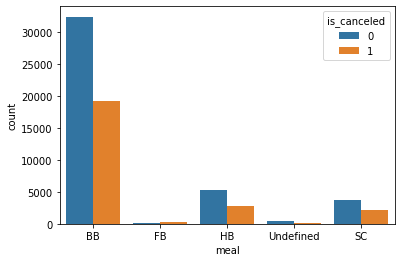

In [52]:
# meal data 확인
df['meal'].unique()

# meal (SC, Undefined = No_meal)
df['meal'].replace('SC','No_meal',inplace=True)
df['meal'].replace('Undefined','No_meal', inplace=True)
df['meal'].unique()
sns.countplot(x='meal',hue='is_canceled',data=service);

- 아침식사만 하는 사람이 많다.

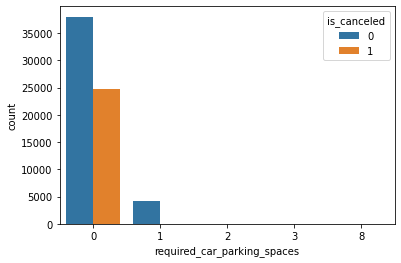

In [53]:
#주차수에 따른 취소여부
sns.countplot(x="required_car_parking_spaces",hue='is_canceled', data=service)

주차 수에 따른 취소 여부가 매우 분명하여 모델에 중요한 특성이 되지 않을까 생각한다.

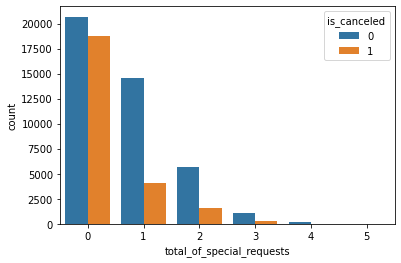

In [54]:
# 특별요청 수에 따른 취소여부
sns.countplot(x="total_of_special_requests",hue='is_canceled', data=service)

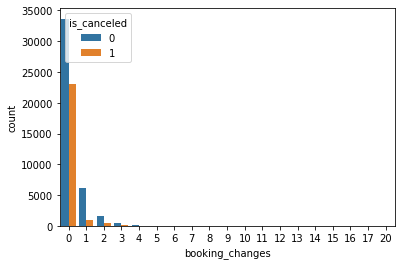

In [55]:
#예약변경 횟수에 따른 취소여부
sns.countplot(x="booking_changes",hue='is_canceled', data=service)

예약 변경을 1회 이상 할 수록 예약을 취소할 확률이 적다.

---

### **모델 만들기**

기준모델 정확도 : 62.9%

In [56]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [57]:
# tran/val/test 데이터 분할하기
from sklearn.model_selection import train_test_split
train, test = train_test_split(whole, test_size=0.20, 
                              random_state=10)
train, val = train_test_split(train, test_size=0.30, 
                              random_state=10)
train.shape, val.shape, test.shape

((66838, 29), (28646, 29), (23871, 29))

In [58]:
target= 'is_canceled'
features = whole.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [59]:
# 모델 1 : Decision Tree

import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

#학습

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=10,max_depth=3)

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

dt_clf.fit(X_train_encoded, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

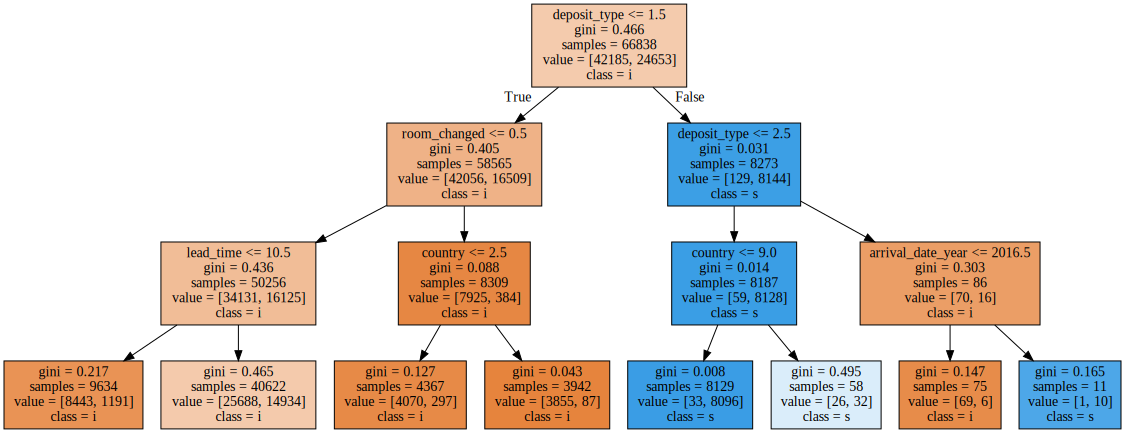

In [60]:
from sklearn.tree import export_graphviz
import warnings

# export_graphviz() 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(dt_clf, out_file="tree.dot", class_names=target, feature_names = features, impurity=True, filled=True)

import graphviz
with open("tree.dot") as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

- 지니계수가 가장 높은 deposit type 부터 나뉘기 시작한다. 너무 깊은 트리를 만들지 않기 위해 다음 모델들도 파라미터를 조정해준다.

In [61]:
#모델 1 : 랜덤포레스트

pipe_rf = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state= 10, n_jobs=-1, oob_score=True, n_estimators=100)
)

pipe_rf.fit(X_train, y_train)
pred= pipe_rf.predict(X_val)

def get_clf_eval(y_val, pred) :
  confusion = confusion_matrix(y_val, pred)
  accuracy = accuracy_score(y_val, pred)
  precision = precision_score(y_val, pred)
  recall = recall_score(y_val, pred)
  f1score = f1_score(y_val, pred)
  report= classification_report(y_val,pred)

  print('오차행렬')
  print(confusion)
  print('\n정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, f1 score :{3:.4f}'.format(accuracy,precision,recall,f1score))
  print(report)

get_clf_eval(y_val, pred)

pred_proba = pipe_rf.predict_proba(X_val)[:,1]
roc_score = roc_auc_score(y_val, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

오차행렬
[[16671  1188]
 [ 2024  8763]]

정확도:0.8879, 정밀도:0.8806, 재현율:0.8124, f1 score :0.8451
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17859
           1       0.88      0.81      0.85     10787

    accuracy                           0.89     28646
   macro avg       0.89      0.87      0.88     28646
weighted avg       0.89      0.89      0.89     28646

ROC AUC 값 : 0.9569


- 파라미터를 조정하지 않은 랜덤포래스트 자체의 정확도가 높다.

In [62]:
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ordinalencoder', 'randomforestclassifier', 'ordinalencoder__cols', 'ordinalencoder__drop_invariant', 'ordinalencoder__handle_missing', 'ordinalencoder__handle_unknown', 'ordinalencoder__mapping', 'ordinalencoder__return_df', 'ordinalencoder__verbose', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomfor

In [63]:
max_depth_list = range(1,10)
train_acc_list=[]
val_acc_list = []

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

for max_depth in max_depth_list:
  tree = RandomForestClassifier(max_depth=max_depth)
  tree.fit(X_train_encoded, y_train)

  pred_train = tree.predict(X_train_encoded)
  pred_val = tree.predict(X_val_encoded)
  
  train_acc_list.append(accuracy_score(y_train, pred_train))
  val_acc_list.append(accuracy_score(y_val, pred_val))

import pandas as pd
d = {"max_depth ":max_depth_list,
     "Train정확도":train_acc_list,
     "Val정확도":val_acc_list
     }
acc_df = pd.DataFrame(d)
acc_df
  

,max_depth,Train정확도,Val정확도
0,1,0.750411,0.742023
1,2,0.768036,0.759373
2,3,0.769742,0.760874
3,4,0.770759,0.762061
4,5,0.771821,0.763073
5,6,0.812292,0.804859
6,7,0.821509,0.813971
7,8,0.835468,0.829505
8,9,0.849008,0.842526


In [64]:
#모델 1-2 : 랜덤포레스트 튜닝

pipe_rf = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state= 10, n_jobs=-1, oob_score=True, n_estimators=300)
)

params_rf = {
    'randomforestclassifier__max_depth' : [3,8,12],
    'randomforestclassifier__min_samples_leaf' : [3,8],
    'randomforestclassifier__min_samples_split' : [3,8]
}

grid_rf = RandomizedSearchCV(pipe_rf, param_distributions=params_rf, cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_rf.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_rf.best_score_))

pred = grid_rf.predict(X_val)
get_clf_eval(y_val, pred)

pred_proba = grid_rf.predict_proba(X_val)[:,1]
roc_score = roc_auc_score(y_val, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

최적 하이퍼 파라미터:
 {'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 12}
최고 예측 정확도: 0.8644
오차행렬
[[16867   992]
 [ 3032  7755]]

정확도:0.8595, 정밀도:0.8866, 재현율:0.7189, f1 score :0.7940
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     17859
           1       0.89      0.72      0.79     10787

    accuracy                           0.86     28646
   macro avg       0.87      0.83      0.84     28646
weighted avg       0.86      0.86      0.86     28646

ROC AUC 값 : 0.9396


- 랜덤포레스트 튜닝 결과 : 정확도가 더 떨어짐 
- 하이퍼 파라미터를 더 조정 할 수 있겠지만 속도가 너무 느려서 안하는게 나을 듯.

In [65]:
# 모델 2 : XGBoost 모델
%%time
pipe_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=100
                  , random_state=10
                  , n_jobs=-1
                  , learning_rate=0.2
                 )
)

pipe_xgb.fit(X_train, y_train);
pred= pipe_xgb.predict(X_val)
get_clf_eval(y_val, pred)

pred_proba = pipe_xgb.predict_proba(X_val)[:,1]
roc_score = roc_auc_score(y_val, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

오차행렬
[[16445  1414]
 [ 2600  8187]]

정확도:0.8599, 정밀도:0.8527, 재현율:0.7590, f1 score :0.8031
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     17859
           1       0.85      0.76      0.80     10787

    accuracy                           0.86     28646
   macro avg       0.86      0.84      0.85     28646
weighted avg       0.86      0.86      0.86     28646

ROC AUC 값 : 0.9365
CPU times: user 9.84 s, sys: 63.8 ms, total: 9.91 s
Wall time: 5.42 s


In [66]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ordinalencoder', 'xgbclassifier', 'ordinalencoder__cols', 'ordinalencoder__drop_invariant', 'ordinalencoder__handle_missing', 'ordinalencoder__handle_unknown', 'ordinalencoder__mapping', 'ordinalencoder__return_df', 'ordinalencoder__verbose', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__nthread', 'xgbclassifier__objective', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__seed', 'xgbclassifier__silent', 'xgbclassifier__subsample', 'xgbclassifier__verbosity'])

In [67]:
# 모델 2-2 : XGBoost 모델 튜닝
params_xgb = {
    'xgbclassifier__max_depth' : [5,8,10],
    'xgbclassifier__min_samples_leaf' : [8,12],
    'xgbclassifier__min_samples_split' : [8,12]
}

grid_xgb = GridSearchCV(pipe_xgb, param_grid=params_xgb, cv=2, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

pred= grid_xgb.predict(X_val)
get_clf_eval(y_val, pred)

pred_proba = grid_xgb.predict_proba(X_val)[:,1]
roc_score = roc_auc_score(y_val, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

print('GridSearchCV 최적 파라미터:\n', grid_xgb.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_xgb.best_score_))

오차행렬
[[16445  1414]
 [ 1828  8959]]

정확도:0.8868, 정밀도:0.8637, 재현율:0.8305, f1 score :0.8468
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17859
           1       0.86      0.83      0.85     10787

    accuracy                           0.89     28646
   macro avg       0.88      0.88      0.88     28646
weighted avg       0.89      0.89      0.89     28646

ROC AUC 값 : 0.9558
GridSearchCV 최적 파라미터:
 {'xgbclassifier__max_depth': 10, 'xgbclassifier__min_samples_leaf': 8, 'xgbclassifier__min_samples_split': 8}
최고 예측 정확도: 0.8802


In [68]:
 # 모델 3 : LightGBM 모델

pipe_lgbm = make_pipeline(
    OrdinalEncoder(), 
    LGBMClassifier(n_estimators=100
                  , random_state=10
                  , n_jobs=-1
                  , learning_rate=0.2
                 )
)

pipe_lgbm.fit(X_train, y_train);

pred= pipe_lgbm.predict(X_val)
get_clf_eval(y_val, pred)

pred_proba = pipe_lgbm.predict_proba(X_val)[:,1]
roc_score = roc_auc_score(y_val, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

오차행렬
[[16419  1440]
 [ 2007  8780]]

정확도:0.8797, 정밀도:0.8591, 재현율:0.8139, f1 score :0.8359
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     17859
           1       0.86      0.81      0.84     10787

    accuracy                           0.88     28646
   macro avg       0.88      0.87      0.87     28646
weighted avg       0.88      0.88      0.88     28646

ROC AUC 값 : 0.9521


In [69]:
pipe_lgbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ordinalencoder', 'lgbmclassifier', 'ordinalencoder__cols', 'ordinalencoder__drop_invariant', 'ordinalencoder__handle_missing', 'ordinalencoder__handle_unknown', 'ordinalencoder__mapping', 'ordinalencoder__return_df', 'ordinalencoder__verbose', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight', 'lgbmclassifier__min_split_gain', 'lgbmclassifier__n_estimators', 'lgbmclassifier__n_jobs', 'lgbmclassifier__num_leaves', 'lgbmclassifier__objective', 'lgbmclassifier__random_state', 'lgbmclassifier__reg_alpha', 'lgbmclassifier__reg_lambda', 'lgbmclassifier__silent', 'lgbmclassifier__subsample', 'lgbmclassifier__subsample_for_bin', 'lgbmclassifier__subsample_freq'])

In [70]:
 # 모델 3-2 : LightGBM 모델 튜닝

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = LGBMClassifier(
    n_estimators=300, 
    learning_rate=0.2,
    n_jobs=-1
)

params = {'lgbmclassifier__num_leaves': [3,10,20],
          'lgbmclassifier__max_depth': [3,10,20],
          'lgbmclassifier__min_child_samples':[5,10,20],
          'lgbmclassifier__subsample': [0.5,0.9]}

gridcv = GridSearchCV(model, param_grid=params, cv=2)
gridcv.fit(X_train_encoded, y_train, early_stopping_rounds=5, eval_metric="accuracy", eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)])

print('GridSearchCV 최적 파라미터:\n', gridcv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(gridcv.best_score_))



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[18]	valid_0's binary_logloss: 0.294231	valid_1's binary_logloss: 0.304473
[19]	valid_0's binary_logloss: 0.292337	valid_1's binary_logloss: 0.30272
[20]	valid_0's binary_logloss: 0.290926	valid_1's binary_logloss: 0.301475
[21]	valid_0's binary_logloss: 0.288786	valid_1's binary_logloss: 0.299642
[22]	valid_0's binary_logloss: 0.286657	valid_1's binary_logloss: 0.297743
[23]	valid_0's binary_logloss: 0.285114	valid_1's binary_logloss: 0.29663
[24]	valid_0's binary_logloss: 0.283988	valid_1's binary_logloss: 0.295939
[25]	valid_0's binary_logloss: 0.282542	valid_1's binary_logloss: 0.294784
[26]	valid_0's binary_logloss: 0.281013	valid_1's binary_logloss: 0.293423
[27]	valid_0's binary_logloss: 0.279547	valid_1's binary_logloss: 0.292228
[28]	valid_0's binary_logloss: 0.278477	valid_1's binary_logloss: 0.291553
[29]	valid_0's binary_logloss: 0.277559	valid_1's binary_logloss: 0.291024
[30]	valid_0's binary_logloss: 0.276619	valid_1's binary_logloss: 

- 하이퍼 파라미터 조정 후 성능이 아주 조금 상승함. 속도가 빠름

---

## 최종 모델 : LightGBoosting
TEST


정확도를 기준으로 한다면 정확도가 가장 높은 randomforest model을 사용해야 하지만, 위에서 만든 모델은 하이퍼 파라미터를 임의의 값으로 설정한 후 만들었기 때문에 작은 차이는 의미가 없다고 판단했다. 그리고 모델의 생성 속도는 몇십 분씩 차이가 났기 때문에 성능이 좋고 제일 빠른 모델인 LightGBM을 선택하였다

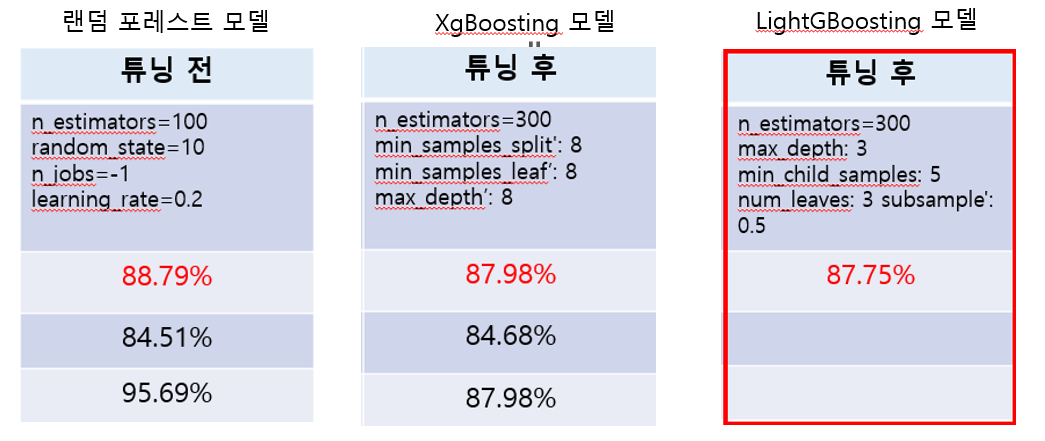

In [71]:
pipe_lgbm = make_pipeline(
    OrdinalEncoder(), 
    LGBMClassifier(n_estimators=300
                  , random_state=10
                  , n_jobs=-1
                  , learning_rate=0.2
                  , max_depth= 3
                  , min_child_samples= 5
                  , num_leaves= 3
                  , subsample= 0.5
                 )
)

pipe_lgbm.fit(X_train, y_train);
pred= pipe_lgbm.predict(X_test)
get_clf_eval(y_test, pred)

pred_proba = pipe_lgbm.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

오차행렬
[[13836  1280]
 [ 2026  6729]]

정확도:0.8615, 정밀도:0.8402, 재현율:0.7686, f1 score :0.8028
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     15116
           1       0.84      0.77      0.80      8755

    accuracy                           0.86     23871
   macro avg       0.86      0.84      0.85     23871
weighted avg       0.86      0.86      0.86     23871

ROC AUC 값 : 0.9370


In [ ]:
pip install eli5

In [92]:
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance


pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('lgbm', LGBMClassifier(n_estimators=300
                            , random_state=10
                            , n_jobs=-1
                            , learning_rate=0.2
                            , max_depth= 3
                            , min_child_samples= 5
                            , num_leaves= 3
                            , subsample= 0.5 ))
])

pipe.named_steps

pipe.fit(X_train, y_train)

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['lgbm'], # model
    scoring='accuracy', # metric
    n_iter=3, 
    random_state=10
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [93]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

cancellation_rating               0.000000
weekend_or_weekday                0.000047
meal                              0.000140
distribution_channel              0.000151
reserved_room_type                0.000151
arrival_date_day_of_month         0.000151
children                          0.000221
is_repeated_guest                 0.000233
total_guest                       0.000256
days_in_waiting_list              0.000256
hotel                             0.000279
total_bill                        0.000838
arrival_date_month                0.000919
stays_nights                      0.001327
adr                               0.001943
previous_bookings_not_canceled    0.004655
booking_changes                   0.006447
arrival_date_year                 0.013300
room_changed                      0.014487
required_car_parking_spaces       0.014627
customer_type                     0.016349
previous_cancellations            0.024948
market_segment                    0.026042
agent      

In [94]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0684 ± 0.0002,country
0.0474 ± 0.0007,total_of_special_requests
0.0423 ± 0.0035,deposit_type
0.0412 ± 0.0033,lead_time
0.0293 ± 0.0011,agent
0.0260 ± 0.0015,market_segment
0.0249 ± 0.0006,previous_cancellations
0.0163 ± 0.0011,customer_type
0.0146 ± 0.0009,required_car_parking_spaces
0.0145 ± 0.0026,room_changed


In [ ]:
!pip install pdpbox
!pip install shap

In [96]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['lead_time', 'adr']

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,  
    features=features
)

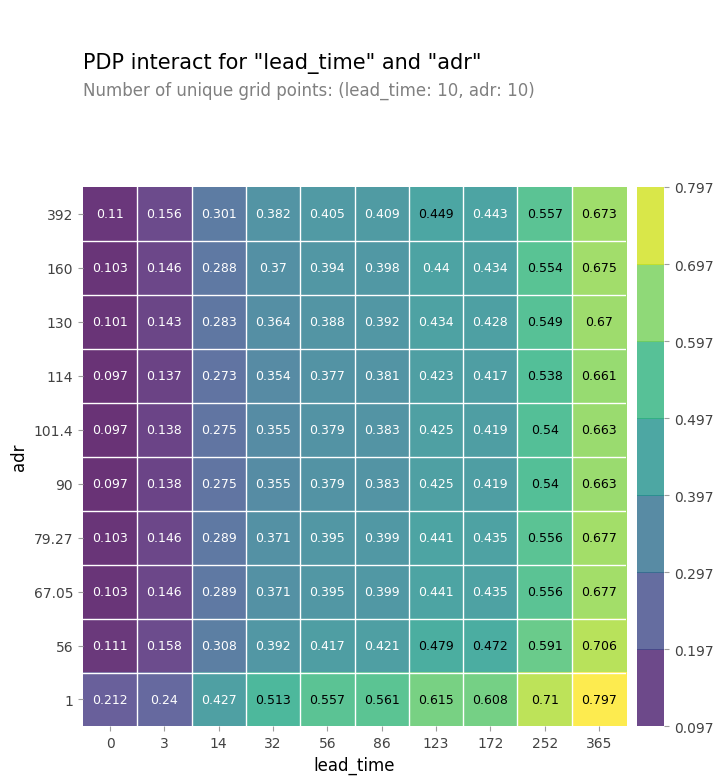

In [97]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

adr(하루평균요금)과 lead_time (예약한 날 이후 경과일)의 특성을 보면 lead_time이 길수록, 하루평균요금이 낮을 수록 취소율은 70% 이상이 된다. 예약한 날 이후 경과일이 0일 경우 하루평균요금은 거의 영향이 없다.

In [98]:
train.shape, val.shape, test.shape

((66838, 29), (28646, 29), (23871, 29))

In [99]:
train.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month', 'children', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'stays_nights', 'total_guest',
       'room_changed', 'total_bill', 'weekend_or_weekday',
       'cancellation_rating'],
      dtype='object')

In [100]:

#target = 'is_canceled'
#X_train = train[features]
#y_train = train[target]
#X_test = test[features]
#y_test = test[target]

In [101]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
#X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

model = LGBMClassifier(
    n_estimators=300, 
    learning_rate=0.2,
    n_jobs=-1,
    num_leaves = 3,
    max_depth = 3,
    min_child_samples = 5,
    subsample = 0.5,
)

model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

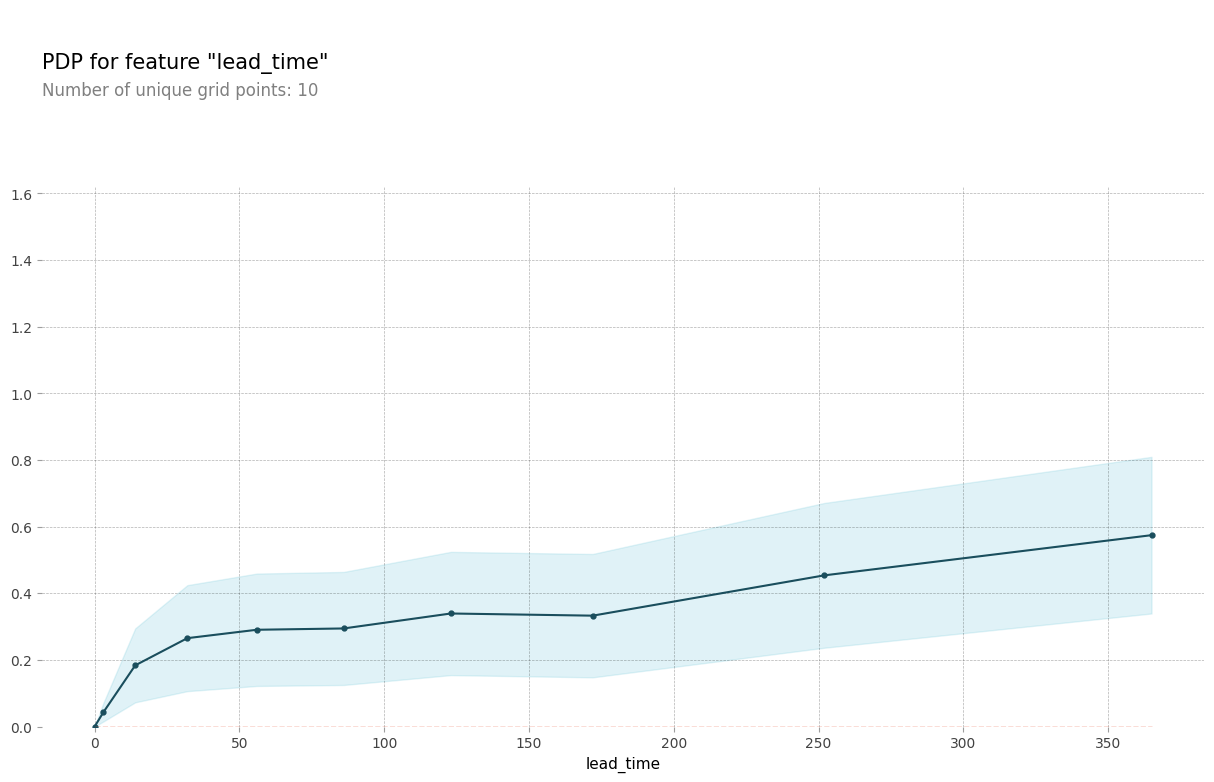

In [102]:
# lead_time PDP
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =100

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'lead_time'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature,
    
)
pdp_plot(isolated, feature_name=feature);

lead_time 에 대한 target의 변화이다. 
예약한 날로부터 경과일이 길어지면 취소율이 높아짐을 알 수 있다.

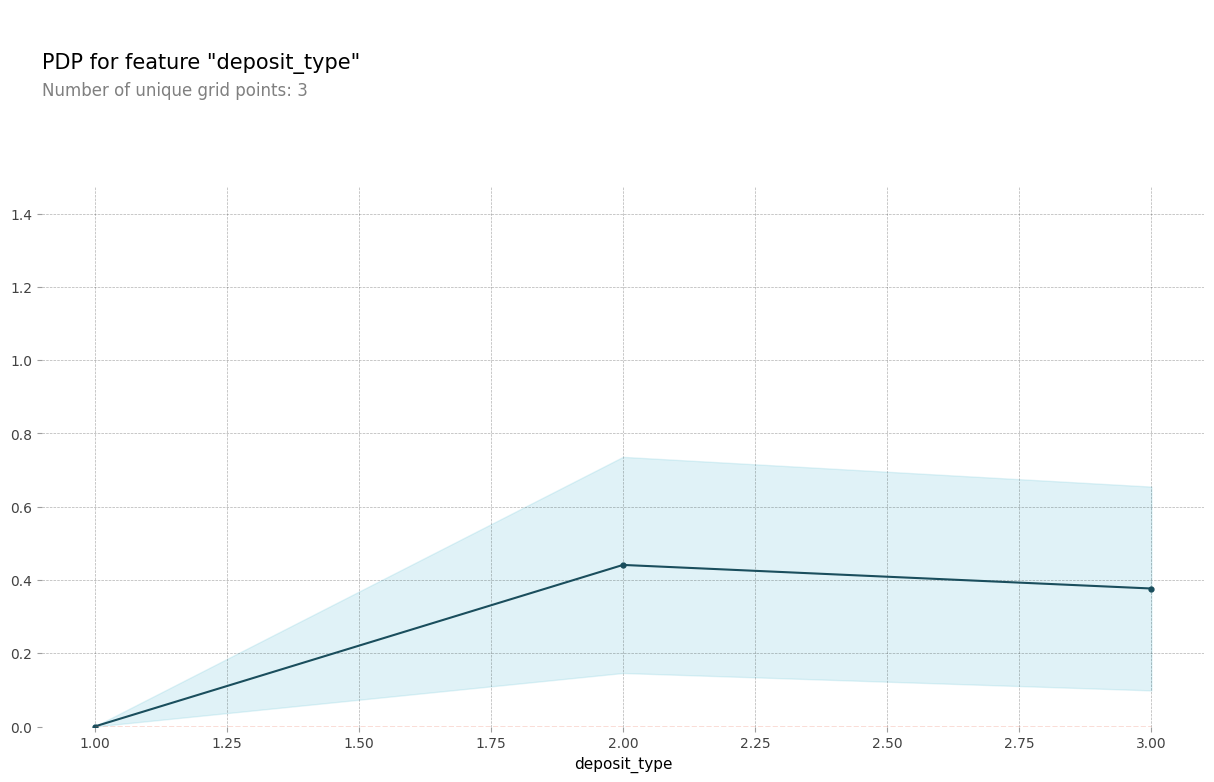

In [103]:
# deposit_type PDP
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =100

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'deposit_type'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    
)
pdp_plot(isolated, feature_name=feature);

보증금이 없는경우 (2) 인 경우 취소확률이 제일 높고 보증금 환급불가(3)일 경우 두번째로 취소확률이 높다.

In [104]:
row = X_test_encoded.iloc[[9900]] 
row

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stays_nights,total_guest,room_changed,total_bill,weekend_or_weekday,cancellation_rating
45994,1,198,2015,9,5,0.0,3,6.0,5,1,0,0,0,2,0,2,11.0,0,1,130.5,0,0,3,3.0,0,391.5,1,1


In [105]:
y_test.iloc[[9900]]

45994    1
Name: is_canceled, dtype: int64

In [106]:
model.predict(row)

array([1], dtype=int64)

In [107]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], row, link='logit')

고객이 예약을 취소한 것에 대한 예측에 영향을 많이 끼친 특성으로 deposit_type(보증금이 없는 경우)이 제일 크다.

In [108]:
row = X_test_encoded.iloc[[1999]]
row

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,children,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,stays_nights,total_guest,room_changed,total_bill,weekend_or_weekday,cancellation_rating
19767,2,0,2016,11,2,0.0,1,2.0,3,3,0,0,0,5,0,1,3.0,0,1,68.0,0,0,1,2.0,0,68.0,2,1


In [109]:
y_test.iloc[[1999]]

19767    0
Name: is_canceled, dtype: int64

In [110]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],row, link='logit' )

0.14 확률로 체크인 할 고객으로 예측하였는데, 가장 큰 이유는 lead_time 즉, 예약한 날이 체크인한 당일이었기 때문입니다. 그 외 보증금 등도 관련있습니다. 확률을 높인 반대특성으로는 국적(포르투갈인)이 있습니다.

## 모델의 사용
- 이 모델은 호텔이 객실을 효율적으로 운영하는 데 도움이 될 것이다.
- 코로나 사유로 인한 예약취소를 제외하여도 여전히 예약률이 수용 제한을 초과할 경우, 잠재적 취소 고객을 예측해 대략 몇명의 고객에게 취소 메일을 보낼 수 있을지, 또 누구에게 보내야 하는지 판단할 수 있다.
- 코로나 상황이 아니더라도 잠재적 취소 고객을 제외하면 얼마나 더 초과예약을 받을 수 있을지 예측해 호텔 피해를 최소한으로 줄일 수 있다.
- 고객의 취소율 등급(신뢰등급) 데이터를 이용해 신뢰있는 고객을 구별하고 등급에 맞는 다양한 이벤트와 혜택을 제공해 고객유치에 힘을 쏟을 수 있다. 예를 들어 신뢰등급이 높은 고객에게 예약대기 우선권을 준다던지 , 신뢰등급이 낮은 고객 순으로 취소메일을 보내는 등
-고객에게 신뢰등급과 그에따른 혜택을 공개하므로써 무분별한 예약취소를 방지하는데 도움이 될 것 같다.

## 모델의 한계
이 모델은 모든 호텔에서 그대로 사용할 수 없다는 한계가 있다. 특정 나라와 호텔의 데이터셋을 바탕으로 만들어진 모델이기 때문이다.
나라마다, 호텔마다 조금씩 분포가 다르게 나타날 것이기 때문에 현재 데이터 상으로는 완벽한 일반화는 불가능하다. 
하지만 각 호텔의 데이터마다 비슷한 모델을 만들어 적용해 볼 수 있을 거라 생각한다.